### Задание:
К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.
### Решение:

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

Часто перед работой по алгоритму kNN требуется проводить нормализацию признаков, так как они могут иметь разные единицы измерения, что может искажать расстояние между объектами.

В общем и целом получается, что при работе с алгоритмом kNN исследователю требуется подобрать три параметра - количество соседей k, метрика расстояния и способ вычисления весов. Для получения лучшего качества работы алгоритма эти параметры нужно подбирать на отложенной выборке или при помощи кросс-валидации.

Реализуем алгоритм kNN с помощью Python.

In [20]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

Загрузим один из "игрушечных" датасетов из sklearn.

In [21]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

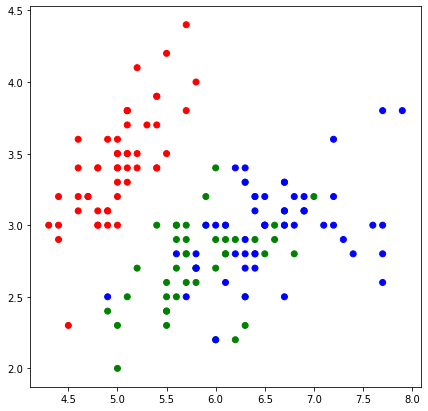

In [23]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [24]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

Добавим веса от расстояния
$w(d) = q^{d}$,   $q \in (0,1)$

In [25]:
def knn(x_train, y_train, x_test, k, q):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            weight = q**d[0]
            classes[d[1]] += weight
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [26]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [27]:
def get_graph(X_train, y_train, k,q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k,q)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [29]:
k,q = 1,0.75

y_pred = knn(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1, q = 0.75: 0.667


Построим график распределения классов.

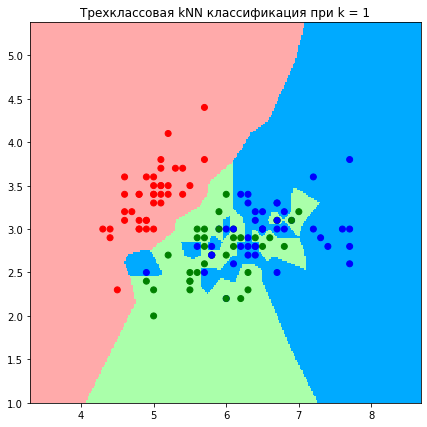

In [30]:
get_graph(X_train, y_train, k,q)

In [31]:
k,q = 3,0.75
y_pred = knn(X_train, y_train, X_test, k,q)
print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3, q = 0.75: 0.733


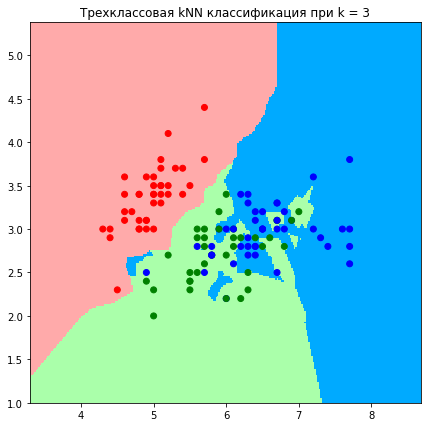

Wall time: 1min 2s


In [32]:
%%time
get_graph(X_train, y_train, k,q)

In [33]:
%%time
k,q = 5,0.75
y_pred = knn(X_train, y_train, X_test, k,q)
print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5, q = 0.75: 0.867
Wall time: 31.2 ms


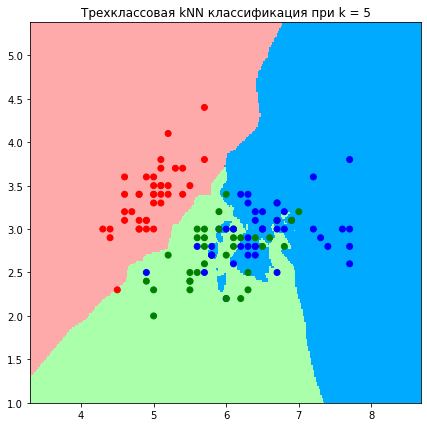

Wall time: 58.6 s


In [34]:
%%time
get_graph(X_train, y_train, k,q)

In [35]:
k,q = 10,0.75
y_pred = knn(X_train, y_train, X_test, k,q)
print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10, q = 0.75: 0.867


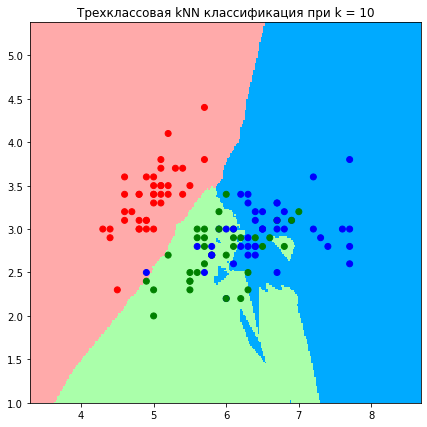

Wall time: 53.4 s


In [36]:
%%time
get_graph(X_train, y_train, k,q)

In [38]:
k,q = 10,0.99

y_pred = knn(X_train, y_train, X_test, k,q)
print(f'Точность алгоритма при k = {k}, q = {q}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10, q = 0.99: 0.867


При увеличении k мы на графиках наблюдаем, как алгоритм меньше концентрируется на выбросах, однако, точность на тестовой выборке при этом увеличивается.

### Задача
__2*. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).__
### Решение

In [19]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

Напишем функцию для визуализации кластеров

In [20]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [21]:
# определим максимальное количество итераций
max_iterations = 1

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

Проверим результат алгоритма после одной итерации

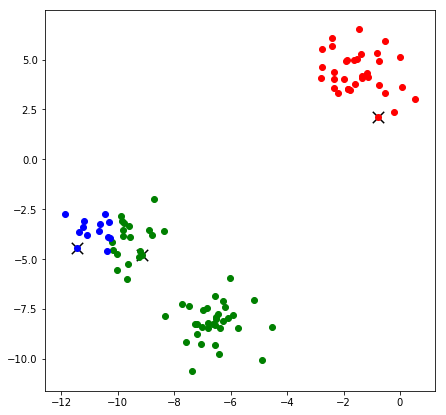

In [22]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Проверим работу алгоритма при различном числе итераций.

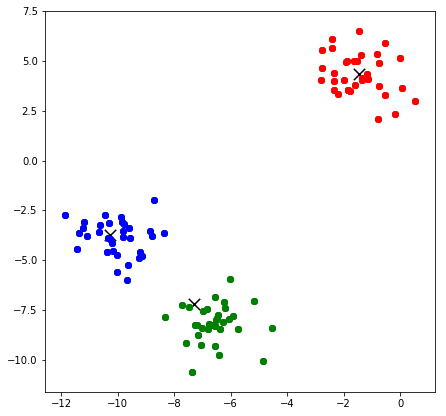

In [23]:
max_iterations = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

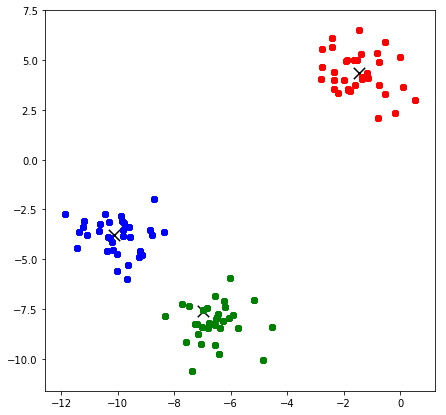

In [24]:
max_iterations = 5

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

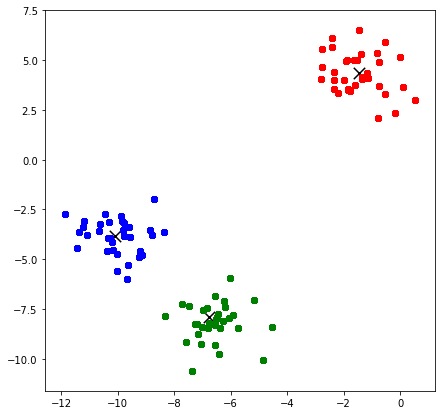

In [25]:
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Видно, как при увеличении количества итераций центроиды перемещаются в центр образующихся кластеров.

Как и говорилось ранее, метод K-means очень чувствителен к выбору начальных центров кластеров, и это является одним из его основных минусов, среди которых также сложность работы с разными формами кластеров (они, например, могут быть вытянутыми, образовывать фигуры и т.п.). В связи с этим существуют другие методы кластеризации, о которых можно прочитать в дополнительных материалах. Там же есть сравнение работы алгоритмов с кластерами различных форм.

## Литература

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)

## Summary

__kNN__
* Метрический алгоритм классификации по "ближайшим соседям"
* Разновидности: ближайший сосед, k ближайших соседей, k взвешанных ближайших соседей
* Алгоритм интерпретируем
* В основе алгоримта лежит *гипотеза компактности*: если мера сходства объектов введена достаточно удачно, то схожие объекты гораздо чаще лежат в одном классе, чем в разных
* Проблемы и их решения
    * Выбор метрики __->__ нет единого алгоритма, позволяющего выбрать метрику, поэтому используют что-то из "стандартного" (например, Евклидова)
    * Выбор числа соседей k __->__ подбор на основании кросс-валидации, чаще даже по контролю одного объекта (leave-one-out cross-validation)
    * Выбросы/шум __->__ ручной отсев, придание меньшего веса, либо поиск типичных представителей классов (эталонов) алгоритмом STOLP, тогда объект можно классифицировать по ближайшему эталону
    * Большие выборки __->__ уменьшение выборки за счет удаления неинформативных объектов (например, оставить только эталоны), либо более быстрые структуры данных (например, kd-деревья)
    * Много признаков - "проклятие размерности" - суммы большого числа отклонений по отдельным признакам с большой вероятностью имеют очень близкие значения (согласно закону больших чисел), то есть в пространстве высокой размерности все объекты примерно одинаково далеки друг от друга __->__ предварительный отбор признаков (feature selection)

__k-means__
* Кластеризует неразмеченные объекты, помогая найти структуру в данных
* Использует метрику близости, является метрическим алгоритмом
* Можно использовать для генерации нового признака - номера кластера
* Проблемы и их решения
    * Алгоритм чувствителен к выбору начальных центров кластеров __->__ как вариант, на начальном этапе принимать в качестве центров самые отдаленные точки
    * Необходимо заранее знать количество кластеров __->__ выбор исходя из природы данных, либо оценка исходя из распределений признаков или 2D представления объектов (PCA)
    * Не справляется с задачей, когда объект принадлежит к разным кластерам в равной степени или не принадлежит ни одному __->__ выбирать случайно ответ, либо ввести более сложную функцию весов
    * Не гарантируется достижение глобального минимума суммарного квадратичного отклонения, а только одного из локальных минимумов (пример на картинке ниже) __->__ инициализировать начальные центры не случайно
    
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/K-means_convergence_to_a_local_minimum.png/1920px-K-means_convergence_to_a_local_minimum.png" style="width: 1000px;">

## Q&A

__1. Можно ли сбалансировать классы в задаче классификации метрическими алгоритмами?__

Да, даже нужно :) Метрические алгоритмы позволяют делать как __up-sampling__ (создавая новые синтетические объекты), так и __down-sampling__ (например, заменяя, кластеры объектов их центроидами). См. библиотеку [imblearn](https://imbalanced-learn.readthedocs.io/en/stable/api.html)

__2. Как можно решить проблему с сильной зависимостью результатов k-means от начальных значений центров кластеров?__

Есть усовершенствованная версия алгоритма __k-means++__, в котором центры инициализируются оптимальным образом:
<img src="L7_Q2_KM++.png" style="width: 1000px;">

Также есть алгоритм __C-means__ (a.k.a. Fuzzy clustering, Soft k-means)
<img src="L7_Q2_CM.png" style="width: 1000px;">

__3. Какова сложность алгоритмов k-means и c-means?__

<img src="L7_Q3.png" style="width: 600px;">

__4. Нужно ли масштабировать/нормировать данные для метрических алгоритмов?__

Да, иначе признаки с наибольшими значениями будут доминировать в метрике, а остальные признаки, фактически, учитываться не будут.

__5. Какие применения в реальной жизни могут быть у kNN и k-means?__

__kNN__

1. Рекомендательные системы - схожим пользователям рекомендуем одинаковые товары/услуги.
2. Обнаружение фрода (мошенничества) - новые случаи мошенничества похожи на те, которые происходили ранее
3. Предсказание отклика клиентов для новых клиентов по историческим данным.
4. Медицина - классификация пациентов по набору показателей и определение потенциальной "склонности" к схожему диагнозу.

__k-means__

1. В задачах глубокого обучения и машинного зрения - создания так называемых фильтров (ядер свёртки, словарей)
2. Кластеризация пользователей по степени активности или платежеспособности для персонализированных подходов
3. Распознавания воздушных объектов - кластеризация объектов в схожие группы (истребитель, бомбардировщик, пассажирский)
4. Векторное квантование цвета - уменьшения цветовой палитры изображения с фиксированным количеством цветов k.